# Compare Sentinel-2 and Venus


 This notebook demonstrates querying the STAC API for a Venus and Sentinel-2 chip using an ROI, calculate the NDVI and plot it as a comparison

## Import and Init Environment

In [2]:
from datetime import timedelta
from glob import glob
import os
import shutil
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from pystac_client import Client
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd
import requests
from odc.stac import stac_load
from PIL import Image

Authenticate with the STAC API, if you get an error check your credentials in `.env`

In [3]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

load_dotenv()  # take environment variables from .env.

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
AUTH_TOKEN_URL = os.getenv("ACCESS_TOKEN_URL")
API_URL = os.getenv("EDS_API_URL")

# Setup requests session
session = requests.Session()
session.auth = (CLIENT_ID, CLIENT_SECRET)


def get_new_token(session):
    """Obtain a new authentication token using client credentials."""
    token_req_payload = {"grant_type": "client_credentials"}
    try:
        token_response = session.post(AUTH_TOKEN_URL, data=token_req_payload)
        token_response.raise_for_status()
        tokens = token_response.json()
        return tokens["access_token"]
    except requests.exceptions.RequestException as e:
        print(f"Failed to obtain token: {e}")

token = get_new_token(session)

catalog = Client.open(API_URL, headers={"Authorization": f"bearer {token}"})

## Bounding Box

In [4]:
def get_bounds_polygon_dict() -> tuple:
    gdf = gpd.read_file("pivot_corumba.geojson")
    polygon = gdf.geometry.iloc[0]
    bounds = polygon.bounds
    return bounds

bbox = get_bounds_polygon_dict()
print(bbox)

(-48.5167190900641, -16.347105333917597, -48.51128016227716, -16.341886209315362)


## Define the config

In [6]:
start_date = "2019-11-01"
end_date = "2020-05-01"
max_clouds = 50 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI

## Helper Functions

In [8]:
def filter_duplicates(items, time_tolerance=timedelta(minutes=5)):
    # Filters items based on acquisition time with a given time tolerance. Useful for getting rid of duplicates
    # from overlapping Sentinel-2 tiles 
    unique_items = []
    seen_times = []

    for item in items:
        acquisition_time = item.datetime
        is_duplicate = any([abs(acquisition_time - seen_time) < time_tolerance for seen_time in seen_times])

        if not is_duplicate:
            unique_items.append(item)
            seen_times.append(acquisition_time)

    return unique_items

def plot_images(site_name, filtered_dataset, offset=0): 
    # Plot images for visualization. Useful for checking if the ROI is correct, whether there are clouds in the 
    # imagery, etc. 
    
    outputs_dir = f"outputs_{site_name}/"  # Location where the output files will be saved
    try: 
        shutil.rmtree(outputs_dir)
    except FileNotFoundError: 
        pass  # That's ok, nothing to cleaup
    os.makedirs(outputs_dir)

    # Loop through each time slice and generate RGB images
    for i in range(len(filtered_dataset.time)):
        ds = filtered_dataset.isel(time=i)
        # Stack the RGB bands into a numpy array
        rgb_numpy_array = np.stack([ds['red'].values, ds['green'].values, ds['blue'].values], axis=-1)

        # Get the date of the current time slice
        date = pd.to_datetime(ds.time.values).strftime("%Y-%m-%d-%s")

        # Apply offset to DN values
        rgb_numpy_array -= offset 
        
        # Clip the values to avoid outliers
        rgb_numpy_array = np.clip(rgb_numpy_array, 0, 2000)

        # Normalize the pixel values between 0 and 1
        rgb_numpy_array = rgb_numpy_array / 2000.0

        # Convert the array to an image and save it
        Image.fromarray((rgb_numpy_array * 255).astype(np.uint8)).save(outputs_dir + f"{site_name}_{date}.png")

    # Get all the saved RGB images
    rgb_images = sorted(glob(outputs_dir + "*.png"))
    print(f"Number of images generated: {len(rgb_images)}")

    # Determine grid layout for displaying images
    n_cols, n_rows = 3, (len(rgb_images) + 2) // 3

    # Plot the RGB images with filenames as titles
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    for ax, png in zip(axes.flatten(), rgb_images):
        ax.imshow(mpimg.imread(png))
        ax.set_title(os.path.basename(png))
        ax.axis('off')

    # Hide any unused axes
    for ax in axes.flatten()[len(rgb_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Query the collection items for Sentinel-2

In [9]:
COLLECTION = "sentinel-2-l2a"
query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}},
)

items = filter_duplicates(list(query.items()))

# Load only the 'scl' band to determine cloud cover first
scl_dataset = stac_load(
    items,
    bands=("scl",),  # Only load the scl band initially
    crs="epsg:3857",  # Projected CRS, as the resolution is in meters
    resolution=5,  # The resolution of the output image in meters
    # chunks={},  # Uncomment if using a dask cluster
    groupby="id",
    bbox=bbox,
)

# Avoid any AOIs with cloud shadow (3) or clouds (8, 9, 10)
# See Table 68 in https://sentinels.copernicus.eu/documents/d/sentinel/s2-pdgs-cs-di-psd-v15-0
# for definition of the SCL mask values 
cloud_values = [3, 8, 9, 10]

# Create a mask where scl values indicate clouds, and calculate percentage cloud
cloud_mask = scl_dataset['scl'].isin(cloud_values)
cloud_fraction = cloud_mask.mean(dim=('x', 'y'))  # Fraction of cloud-covered pixels per time slice

# Filter the scl dataset by cloud-free time slices (e.g., cloud fraction < 1% cloud cover)
cloud_free_indices = (cloud_fraction < 0.000001).values.tolist()
cloud_free_items = [item for item, is_cloud_free in zip(items, cloud_free_indices) if is_cloud_free]
print(f'Filtered from {len(items)} items to {len(cloud_free_items)} cloud-free items')

Filtered from 23 items to 14 cloud-free items


## Generate and load the Sentinel-2 datacube and calculate NDVI

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 122, x: 122, time: 14)
Coordinates:
  * y            (y) float64 976B -1.844e+06 -1.844e+06 ... -1.845e+06
  * x            (x) float64 976B -5.401e+06 -5.401e+06 ... -5.4e+06 -5.4e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 112B 2020-04-27T13:36:54.039000 ... 20...
Data variables:
    red          (time, y, x) uint16 417kB 132 132 139 139 ... 1926 1966 1966
    green        (time, y, x) uint16 417kB 313 313 301 301 ... 1632 1578 1578
    blue         (time, y, x) uint16 417kB 111 111 125 125 ... 1408 1318 1318
    nir          (time, y, x) uint16 417kB 3120 3120 3132 ... 2990 2934 2934
<xarray.Dataset> Size: 676B
Dimensions:      (time: 14)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 112B 2020-04-27T13:36:54.039000 ... 20...
Data variables:
    red          (time) float64 112B 1.718e+03 1.439e+03 ... 1.223e+03 1.796e+03
    green        (time) float64 112B 1.288e+03 1.1

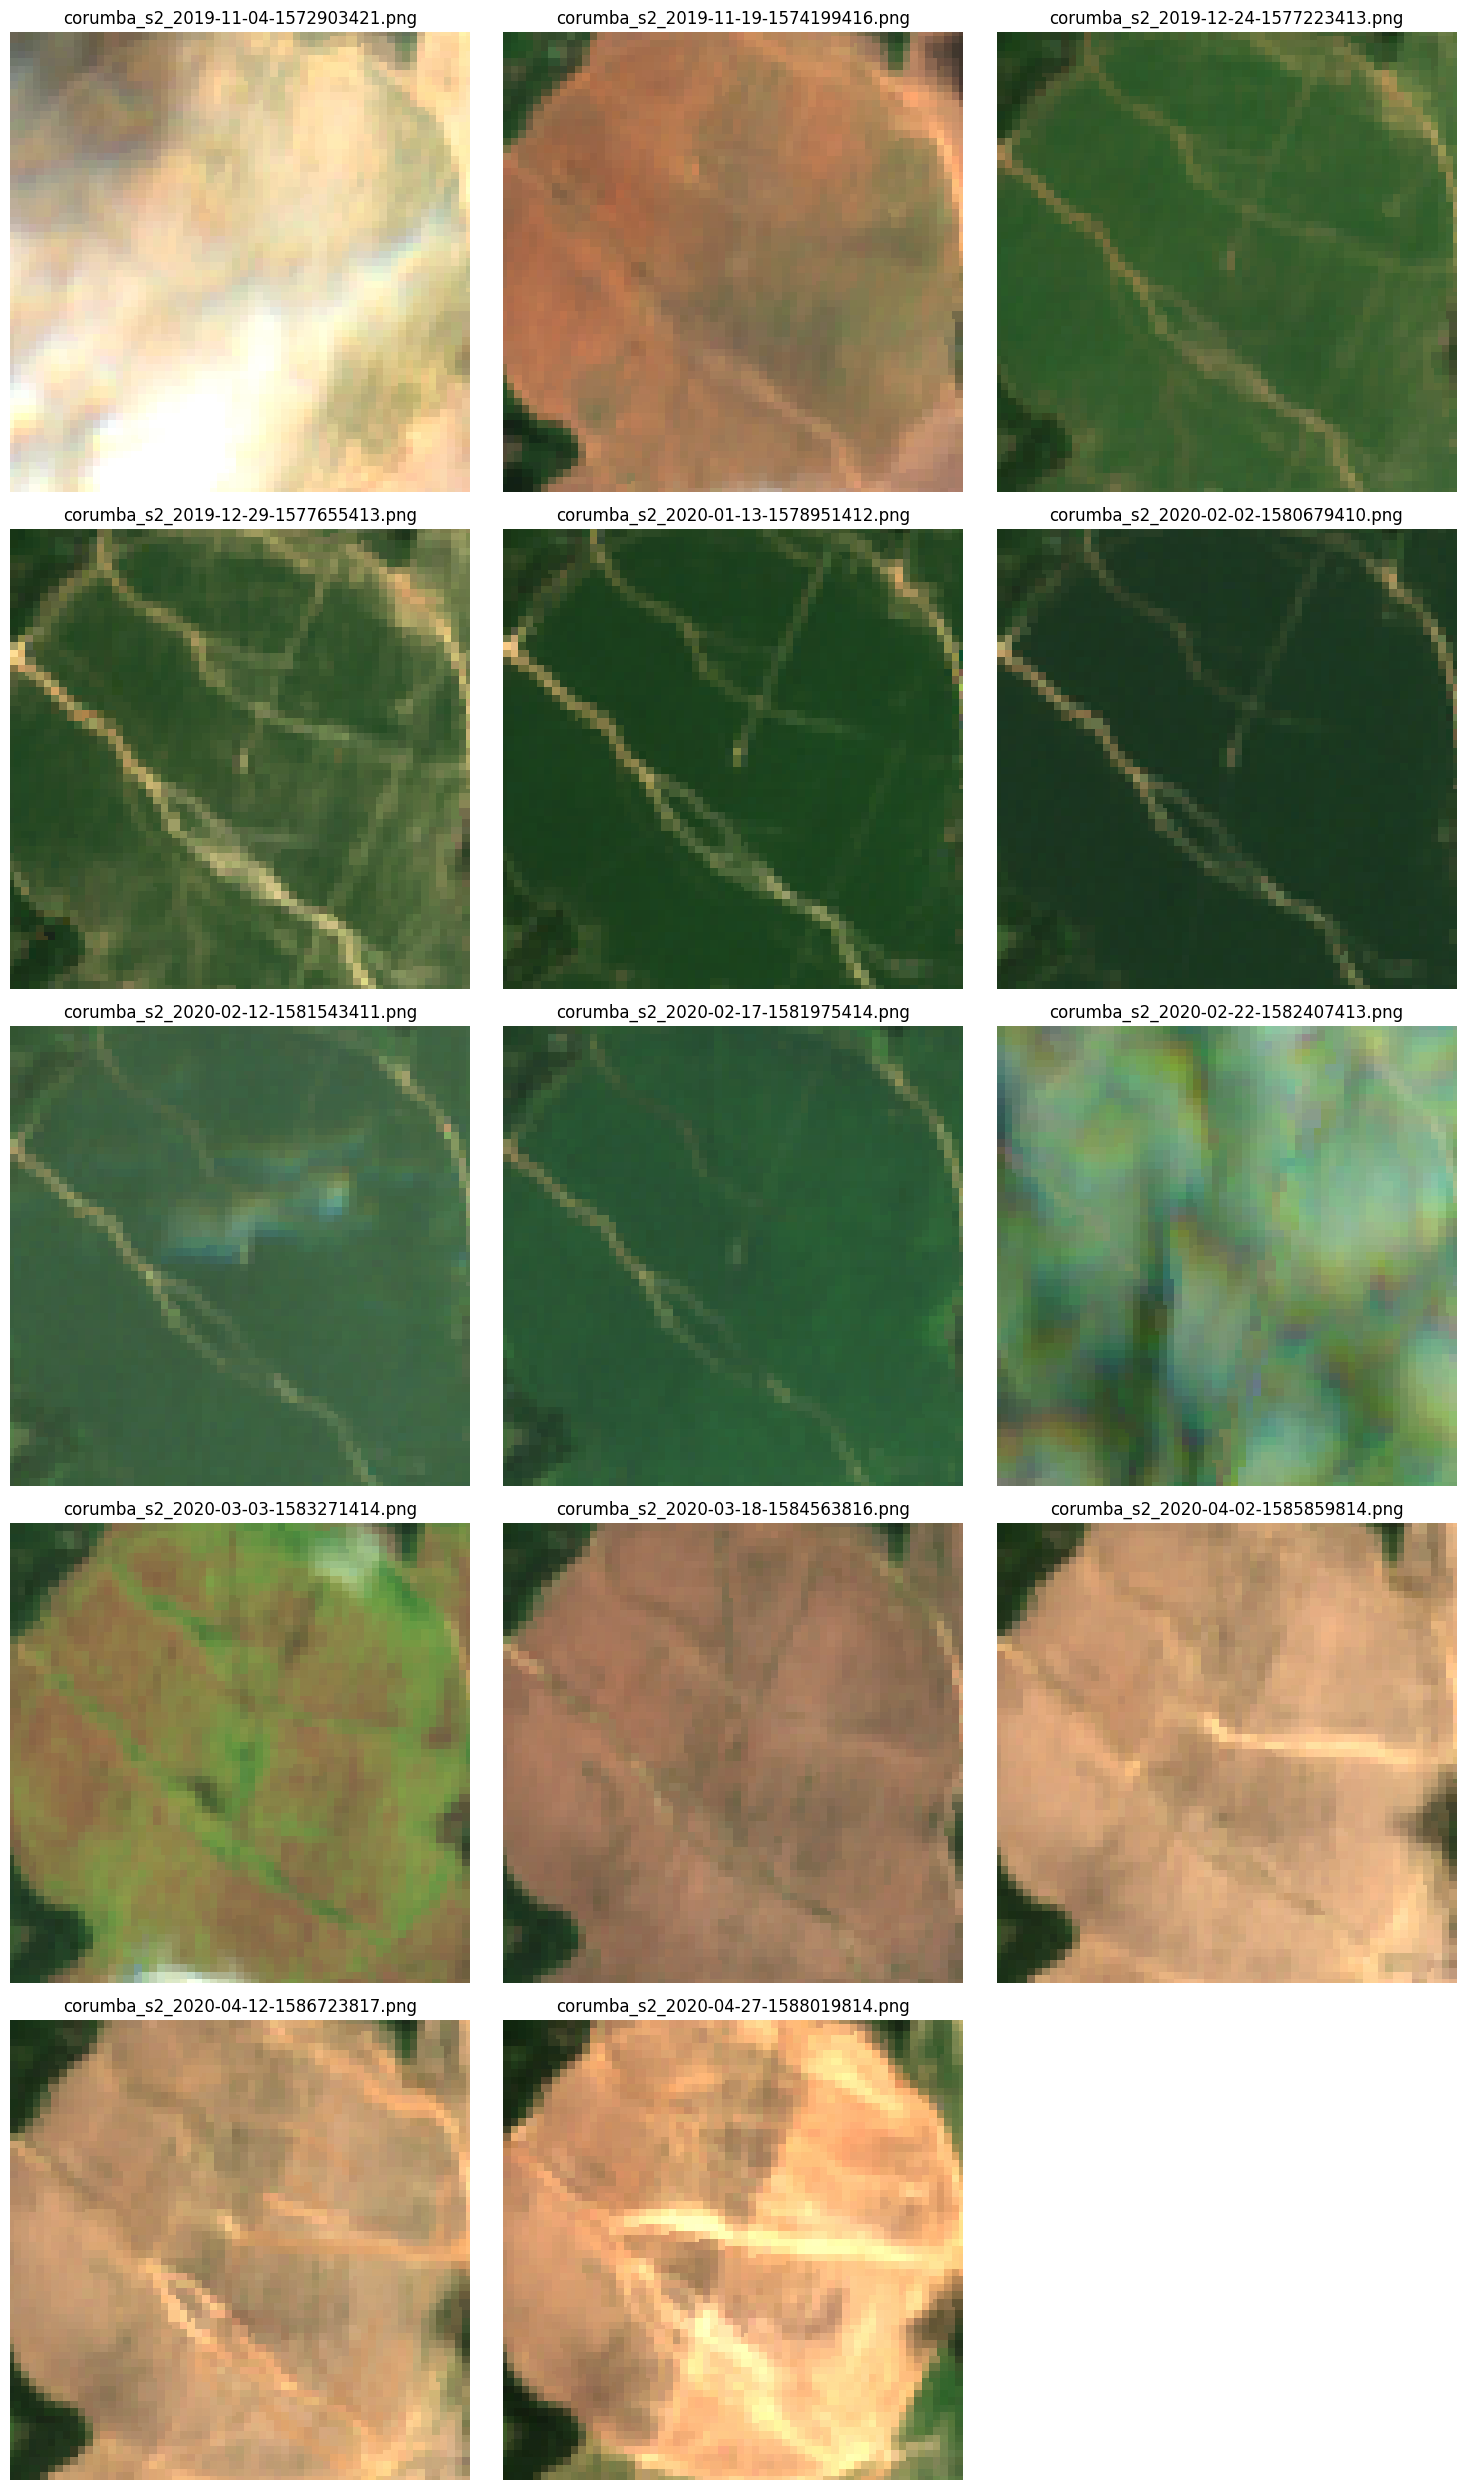

In [10]:
# Now load the other bands (red, green, blue, nir) only for the cloud-free time slices
filtered_dataset = stac_load(
    cloud_free_items,
    bands=("red", "green", "blue", "nir"),  # Load the RGB + nir bands
    crs="epsg:3857",  # Projected CRS
    resolution=5,  # Output image resolution in meters
    groupby="id",
    bbox=bbox
)

# Print the filtered dataset (with RGB and nir bands for cloud-free slices)
print(filtered_dataset)

# NDVI calculation
meanval = filtered_dataset.mean(('x', 'y'))  # Mean over spatial dimensions
meanval.attrs['sensor'] = "Sentinel-2-l2a"

# Calculate NDVI
ndvixy = (meanval["nir"] - meanval["red"]) / (meanval["nir"] + meanval["red"])
meanval["ndvi"] = ndvixy

# Load the meanval into memory
meanval = meanval.load()

# Print the final dataset with NDVI
print(meanval)

# Also plot the images to check 
plot_images('corumba_s2', filtered_dataset)
meanval_s2 = meanval


## Query the items for Venus

In [10]:
COLLECTION = "venus-l2a"
query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}},
)

items = filter_duplicates(list(query.items()))

# Load only the 'scl' band to determine cloud cover first
mask_dataset = stac_load(
    items,
    bands=("mask",),  # Only load the scl band initially
    crs="epsg:3857",  # Projected CRS, as the resolution is in meters
    resolution=5,  # The resolution of the output image in meters
    # chunks={},  # Uncomment if using a dask cluster
    groupby="id",
    bbox=bbox,
)

# Avoid any AOIs with cloud shadow shadow or cloud. See TBD for Venus bits
# Create a mask where scl values indicate clouds, and calculate percentage cloud
# This is bits 1 and 3 in the Venus mask. See https://www.theia-land.fr/wp-content/uploads/2018/12/THEIA-NT-411-0406-CN_Ed0100_20171025.pdf
# page 8 for definition of the mask 
mask_int = mask_dataset['mask'].astype(int)
cloud_mask = ((mask_int & (1 << 1)) != 0) | ((mask_int & (1 << 3)) != 0)
cloud_fraction = cloud_mask.mean(dim=('x', 'y'))  # Fraction of cloud-covered pixels per time slice

# Filter the scl dataset by cloud-free time slices (e.g., cloud fraction < 1% cloud cover)
cloud_free_indices = (cloud_fraction < 0.00001).values.tolist()
cloud_free_items = [item for item, is_cloud_free in zip(items, cloud_free_indices) if is_cloud_free]
print(f'Filtered from {len(items)} items to {len(cloud_free_items)} cloud-free items')

Filtered from 18 items to 13 cloud-free items


## Generate and load the Venus datacube

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 122, x: 122, time: 13)
Coordinates:
  * y            (y) float64 976B -1.844e+06 -1.844e+06 ... -1.845e+06
  * x            (x) float64 976B -5.401e+06 -5.401e+06 ... -5.4e+06 -5.4e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 104B 2020-05-01T13:41:18 ... 2019-11-0...
Data variables:
    red          (time, y, x) uint16 387kB 1200 1210 1210 ... 2620 2620 2650
    green        (time, y, x) uint16 387kB 1350 1360 1360 ... 2260 2240 2230
    blue         (time, y, x) uint16 387kB 1160 1160 1170 ... 1990 1990 1970
    nir08        (time, y, x) uint16 387kB 4220 4310 4300 ... 3510 3520 3530
<xarray.Dataset> Size: 628B
Dimensions:      (time: 13)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 104B 2020-05-01T13:41:18 ... 2019-11-0...
Data variables:
    red          (time) float64 104B 1.59e+03 1.666e+03 ... 1.053e+03 1.625e+03
    green        (time) float64 104B 1.12e+03 1.195e+0

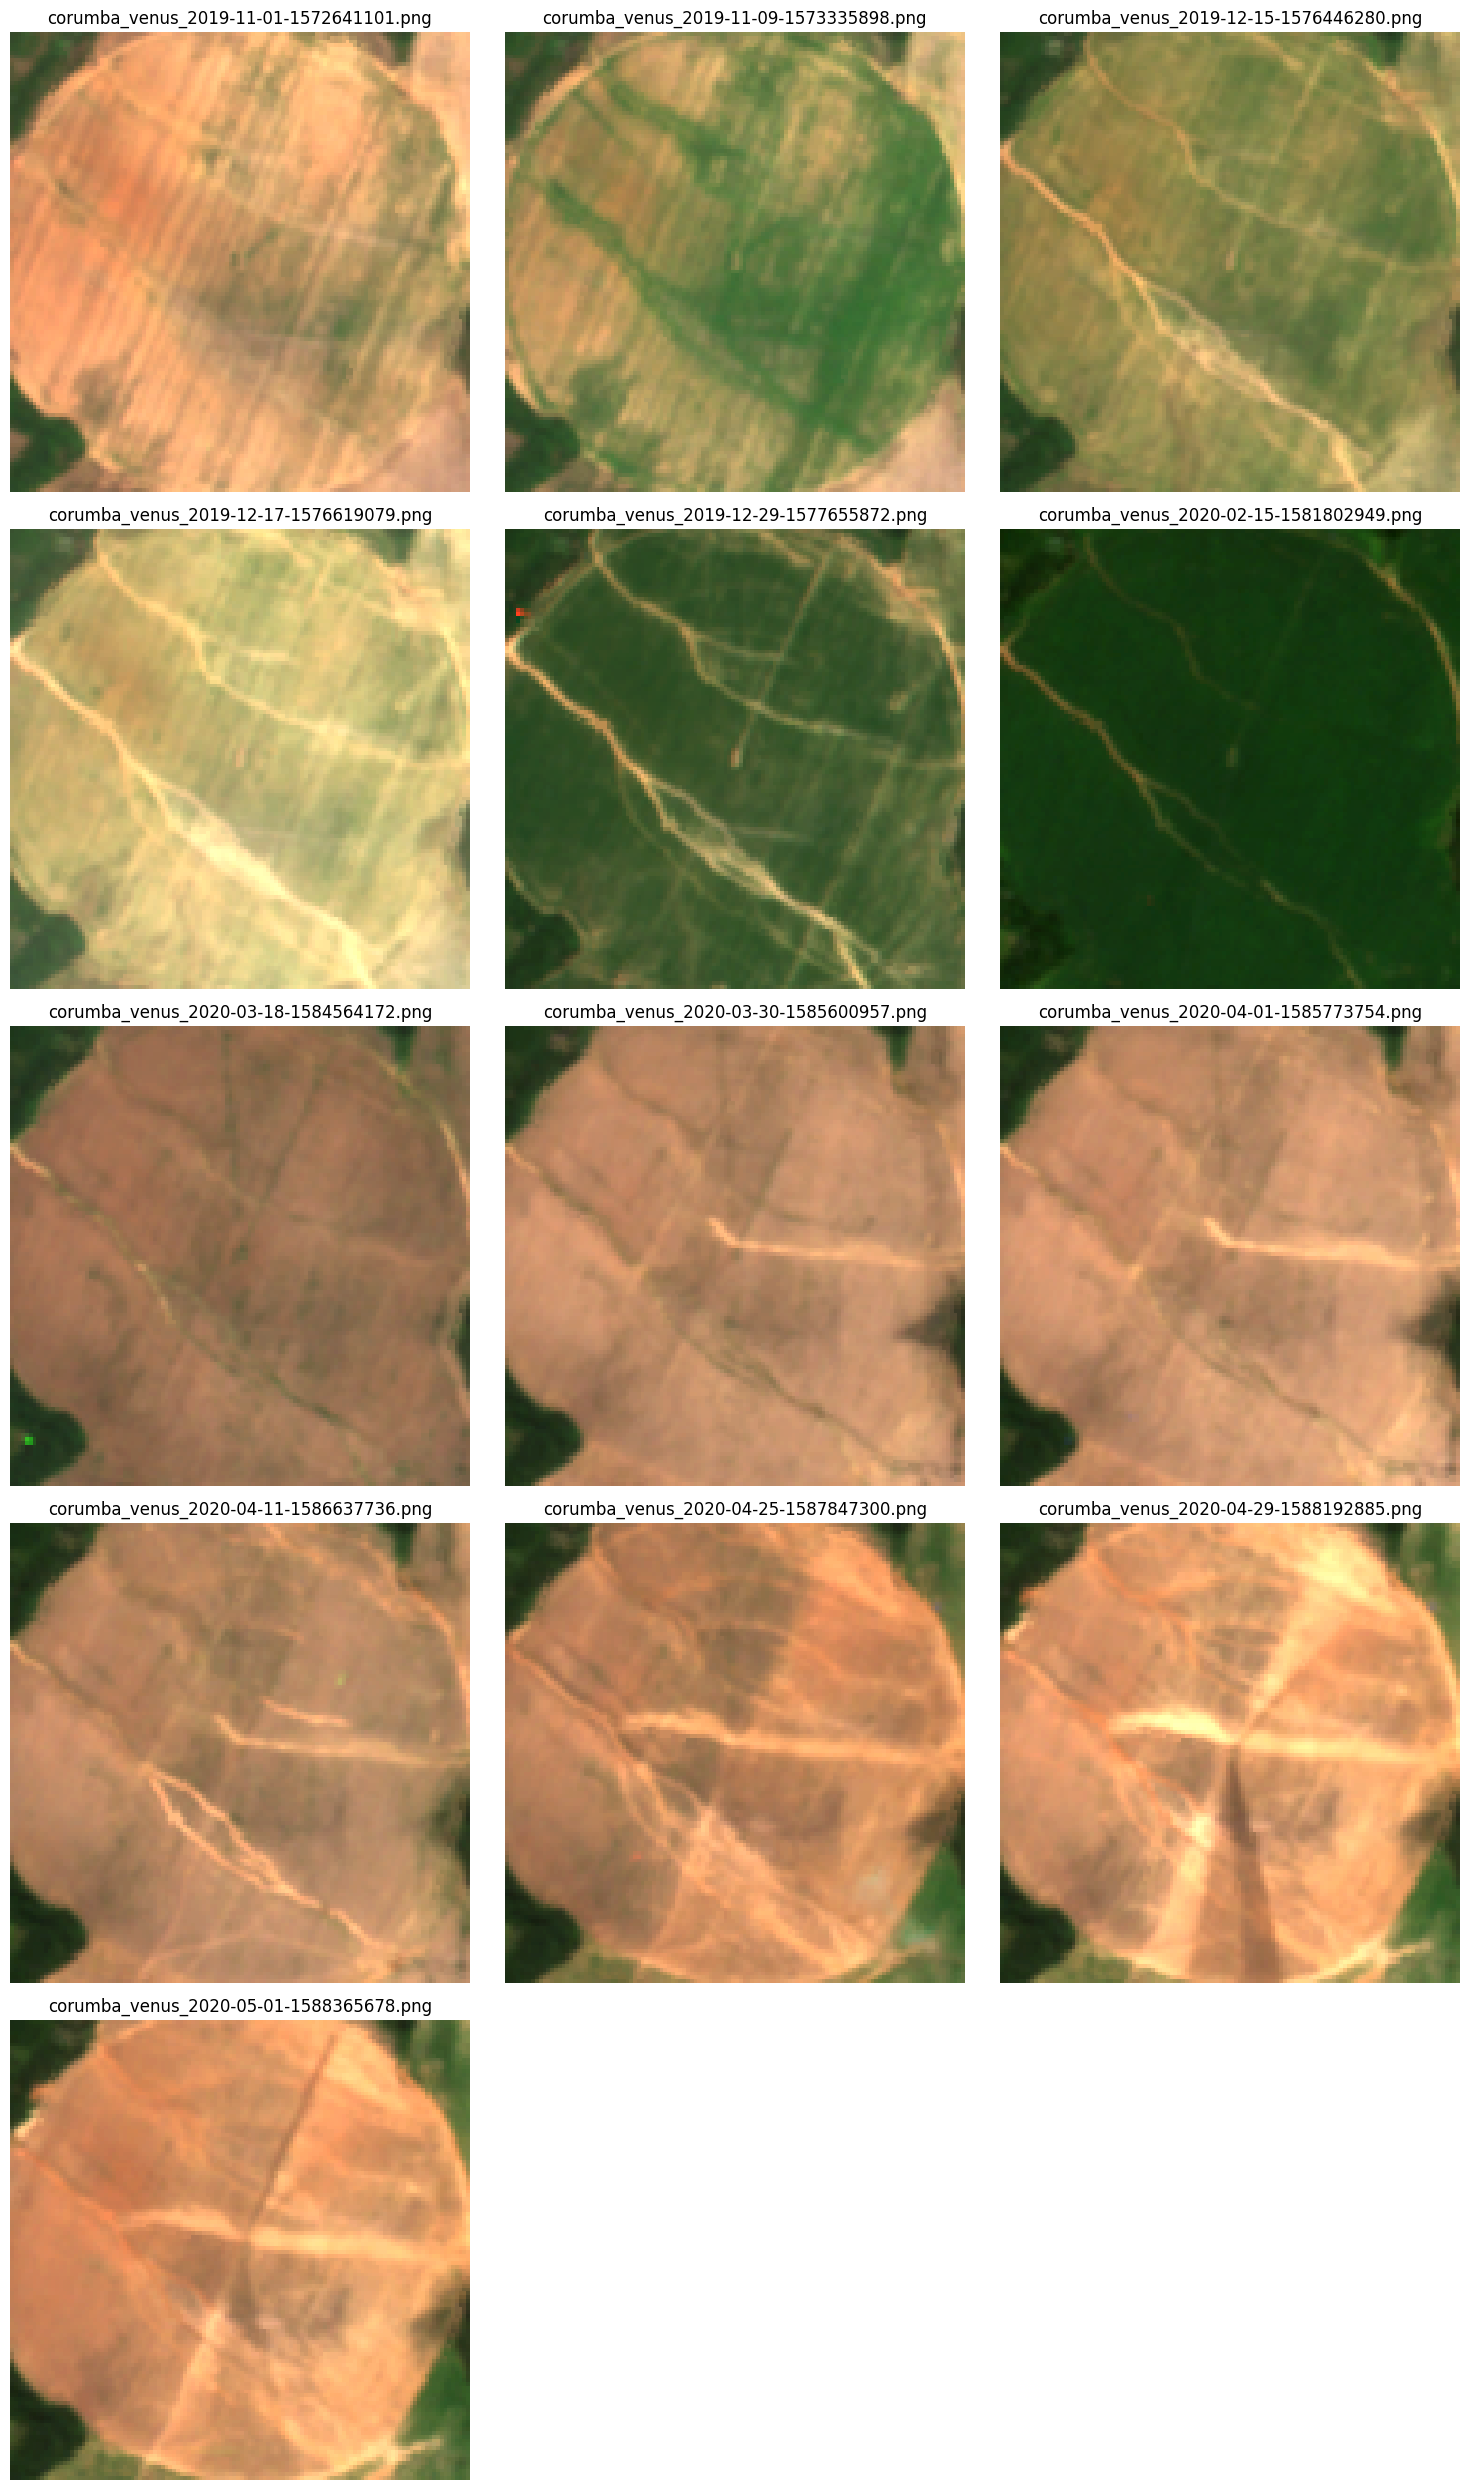

In [12]:
# Now load the other bands (red, green, blue, nir) only for the cloud-free time slices
filtered_dataset = stac_load(
    cloud_free_items,
    bands=("red", "green", "blue", "nir08"),  # Load the RGB + nir bands
    crs="epsg:3857",  # Projected CRS
    resolution=5,  # Output image resolution in meters
    groupby="id",
    bbox=bbox
)

# Print the filtered dataset (with RGB and nir bands for cloud-free slices)
print(filtered_dataset)

# NDVI calculation
meanval = filtered_dataset.mean(('x', 'y'))  # Mean over spatial dimensions
meanval.attrs['sensor'] = "Venus-L2A"

# Calculate NDVI
meanval = meanval - 1000  # Venus has a 1000 offset. 1000 = 0.0 reflectance, 11000 = 1.0 reflectance
ndvixy = (meanval["nir08"] - meanval["red"]) / (meanval["nir08"] + meanval["red"])
meanval["ndvi"] = ndvixy

# Load the meanval into memory
meanval = meanval.load()

# Print the final dataset with NDVI
print(meanval)

# Also plot the images to check 
plot_images('corumba_venus', filtered_dataset, offset=1000)
meanval_venus = meanval 

# Results (plots)

## Plot and Compare the NDVI

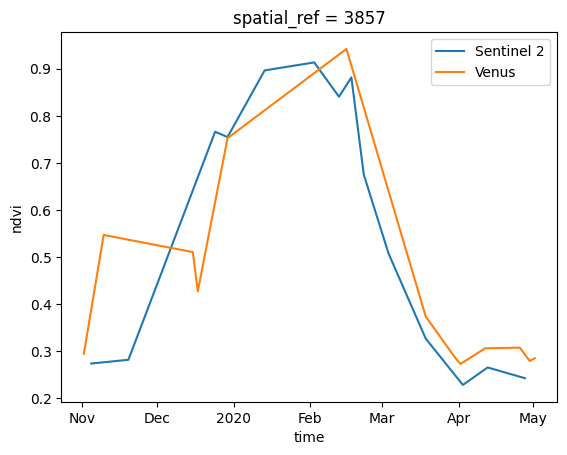

In [14]:

plt.title('NDVI between Sentinel-2 and Venus')

meanval_s2["ndvi"].plot()
meanval_venus["ndvi"].plot()
plt.legend(['Sentinel 2','Venus'])
    
plt.show()